# Daedalus Height Integrated Products

Calculation started...
Calculation executed!
Total run time: 23.995589017868042 seconds


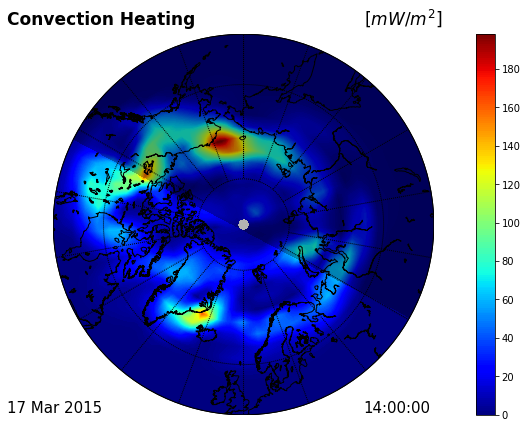

Calculation started...
Calculation executed!
Total run time: 24.473296642303467 seconds


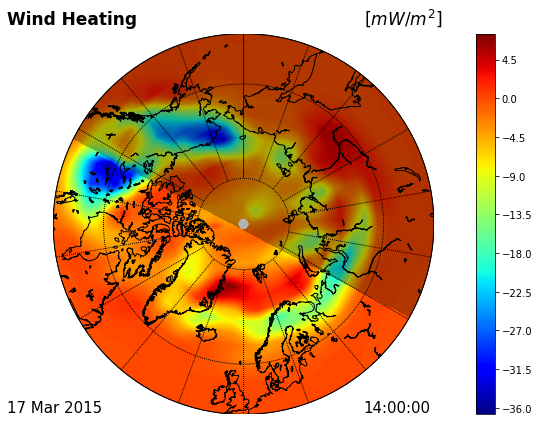

Calculation started...
Calculation executed!
Total run time: 24.143561601638794 seconds


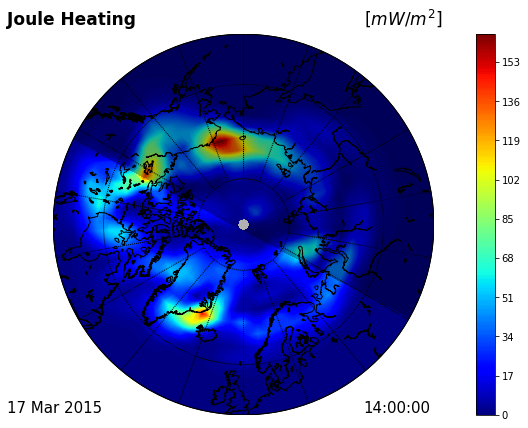

In [3]:
#import required packages
import sys
sys.path.insert(1, "../SourceCode")
import DaedalusGlobals as DaedalusGlobals
from netCDF4 import Dataset
import numpy as np
import datetime
import pyglow
from ipywidgets import*
import ipywidgets as widgets
import warnings
import glob
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from mpl_toolkits.basemap import Basemap, shiftgrid, addcyclic
import matplotlib.mlab as mlab
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.interpolate import griddata
from pylab import *
from matplotlib.patches import Polygon
import time
import pandas as pd
import image


# Allocations

Sigma_P=np.zeros((72,144),order='F')
Sigma_H=np.zeros((72,144),order='F')
QA_h=np.zeros((72,144),order='F')
QW_h=np.zeros((72,144),order='F')
QJ_h=np.zeros((72,144),order='F')
maptime=np.zeros((24),order='F')
maplat=np.zeros((72),order='F')
maplon=np.zeros((144),order='F')


def run_map(tiegcm_file,timer_value):
    # Initializations
    
    start_time = time.time()
    time_igrf = datetime.datetime(2015, 3, 15, 0, 0, 0)  # first time step of the TIEGCM run
    timer = 0  # counter used for incrementing TIEGCM timestep
    deltalmd = 2.5  # TIEGCM grid resolution in deg
    deltaphi = 2.5  # TIEGCM grid resolution in deg
    Re = 6378.1370  # Earths Radius (km)
    electron = 1.602176565 * 10 ** (- 19) #electron charge in C
    boltzmann=1.380645852 * 10 ** (-16) #Boltzmann constant in cm^2*g*s^(-2)*K^(-1)
    me=9.10938356 * 10 ** (- 31) #electron mass in kg
    mO=16 # Oxygen atomic mass in g/mol
    mN2=28  #N2 molecular mass in g/mol
    mO2=32 #O2 molecular mass in g/mol
    mNO=30 #NO molecular mass in g/mol
    NA=6.02214086 * 10 ** 23 #Avogadro's constant in mol^-1
    fcor=1.5 #Burnside facor (default=1.5)
    
    #Input file
    TIEGCM = Dataset(tiegcm_file)

    # Get data from TIEGCM Model file
    glat = TIEGCM.variables['lat'][:] #geographic latitude in deg
    glon = TIEGCM.variables['lon'][:] #geographic longitude in deg
    glev = TIEGCM.variables['ilev'][:] #interface levels
    gtime = TIEGCM.variables['time'][:]
    zg = TIEGCM.variables['ZGMID'][:] #Geometric height in cm
    PED_all = TIEGCM.variables['PEDERSEN'][:] #Pedersen conductivity in Si/m
    HALL_all= TIEGCM.variables['HALL'][:] #Hall conductivity in Si/m
    QAMIE_all=TIEGCM.variables['QAMIE'][:]
    QWIND_all=TIEGCM.variables['QWIND'][:]
    TIEGCM.close() #close input file
    
    Sigma_P_tmp=np.zeros((len(glev), len(glat), len(glon)),order='F')
    Sigma_H_tmp=np.zeros((len(glev), len(glat), len(glon)),order='F')
    QA_temp=np.zeros((len(glev), len(glat), len(glon)),order='F')
    QW_temp=np.zeros((len(glev), len(glat), len(glon)),order='F')
    QJ_temp=np.zeros((len(glev), len(glat), len(glon)),order='F')

    for timer in range(timer_value,timer_value+1):
            time_plot=gtime[timer]
            maptime[timer]=time_plot

            for lev in range(0, len(glev)-1):

                for lat in range(0, len(glat)):

                    for lon in range(0, len(glon)):

                            # GEO coordinates of desired point
                        alt_p_0 = zg[timer, lev, lat, lon] / 100 #cm to m
                        alt_p_1 = zg[timer, lev+1, lat, lon] / 100 #cm to m
                        lat_p = glat[lat]   #deg
                        lon_p = glon[lon]   #deg
                        maplat[lat]=glat[lat] #output 
                        maplon[lon]=glon[lon] #output 
                        timeg=gtime[timer]

                        delta_z=(alt_p_1-alt_p_0)

                        SP=(PED_all[timer,lev,lat,lon]+PED_all[timer,lev+1,lat,lon])/2

                        SH=(HALL_all[timer,lev,lat,lon]+HALL_all[timer,lev+1,lat,lon])/2

                        QA=(QAMIE_all[timer,lev,lat,lon]+QAMIE_all[timer,lev+1,lat,lon])/2

                        QW=(QWIND_all[timer,lev,lat,lon]+QWIND_all[timer,lev+1,lat,lon])/2
                        
                        QJ=(QAMIE_all[timer,lev,lat,lon]+QWIND_all[timer,lev,lat,lon]+QAMIE_all[timer,lev+1,lat,lon]+QWIND_all[timer,lev+1,lat,lon])/2

                        SIGMAPEDERSEN=SP*delta_z

                        SIGMAHALL=SH*delta_z
                        QAMIE_T=QA*delta_z
                        QWIND_T=QW*delta_z
                        QJOULE_T=QJ*delta_z

                        Sigma_P_tmp[lev,lat,lon]=SIGMAPEDERSEN
                        Sigma_H_tmp[lev,lat,lon]=SIGMAHALL
                        QA_temp[lev,lat,lon]=QAMIE_T
                        QW_temp[lev,lat,lon]=QWIND_T
                        QJ_temp[lev,lat,lon]=QJOULE_T
                        
                        
                        
                        warnings.simplefilter('ignore')

                        # print (SIGMAPEDERSEN)
    


    for lat in range(0, len(glat)):

        for lon in range(0, len(glon)):

            Sigma_P[lat,lon]=np.sum(Sigma_P_tmp[:-2,lat,lon])
            Sigma_H[lat,lon]=np.sum(Sigma_H_tmp[:-2,lat,lon])
            QA_h[lat,lon]=np.sum(QA_temp[:-2,lat,lon])
            QW_h[lat,lon]=np.sum(QW_temp[:-2,lat,lon])
            QJ_h[lat,lon]=np.sum(QJ_temp[:-2,lat,lon])
            warnings.simplefilter('ignore')

    


    print("Calculation executed!")
    print("Total run time: %s seconds" % (time.time() - start_time))
                
warnings.simplefilter('ignore')

def Joule_polar_plot(param,timer):
    
    
    x_value=maplon[:]
    y_value=maplat[:]
    time_begin=datetime.datetime(2015,3,15,0,0,0)
    time_plot=time_begin+datetime.timedelta(minutes=maptime[timer])
    
    if param == 'Convection Heating':
        parameter = QA_h
    if param == 'Wind Heating':
        parameter = QW_h
    if param == 'Pedersen':
        parameter = Sigma_P
    if param == 'Hall':
        parameter = Sigma_H
    if param == 'Joule Heating':
        parameter = QJ_h
    
    
    #m.fillcontinents(color='gray',lake_color='gray')
    m = Basemap(projection='npstere',boundinglat=50,lon_0=0,resolution='l', round=True,)
    parameter, lons=addcyclic(parameter,x_value)
    lons, parameter = m.shiftdata(lons, datain = parameter, lon_0=0)
    
    lon, lat = np.meshgrid(lons,y_value)
    x, y = m(lon, lat)
    fig = plt.figure(figsize=(15,7))
    #m.fillcontinents(color='gray',lake_color='gray')
    m.drawcoastlines()
    m.drawparallels(np.arange(-80.,81.,20.))
    m.drawmeridians(np.arange(-180.,181.,20.))
    m.drawmapboundary(fill_color='white')
    
   
    if param == 'Convection Heating':
        cs = m.contourf(x,y,parameter,200,cmap='jet')
        plt.colorbar();
        
    if param == 'Wind Heating':
        cs = m.contourf(x,y,parameter,200,cmap='jet')
        plt.colorbar();
    if param == 'Pedersen':
        cs = m.contourf(x,y,parameter,200,cmap='afmhot')
        plt.colorbar();
    if param == 'Hall':
        cs = m.contourf(x,y,parameter,200,cmap='afmhot')
        plt.colorbar();
    if param == 'Joule Heating':
        cs = m.contourf(x,y,parameter,200,cmap='jet')
        plt.colorbar();
   
    if night_checkbox.value == True:
        CS=m.nightshade(time_plot, alpha=0.3)
#     cbJH=plt.colorbar();
    
       
    if param == 'Convection Heating':
#         plt.title("Joule Heating Rate (mW/m^3)_North Pole- %s" % time_plot.strftime("%d %b %Y %H:%M:%S"))
#         cbJH.set_label('Joule Heating Rate [$mW/m^{3}$]')
        fig.text(0.35, 0.90, 'Convection Heating', fontsize=17, fontweight='bold')
        fig.text(0.35, 0.13, "%s" % time_plot.strftime("%d %b %Y"), fontsize=15)
        fig.text(0.68, 0.13, "%s" % time_plot.strftime("%H:%M:%S"), fontsize=15)
        fig.text(0.68, 0.90, "[$mW/m^{2}$]" , fontsize=17)
        
    if param == 'Wind Heating':
        fig.text(0.35, 0.90, 'Wind Heating', fontsize=17, fontweight='bold')
        fig.text(0.35, 0.13, "%s" % time_plot.strftime("%d %b %Y"), fontsize=15)
        fig.text(0.68, 0.13, "%s" % time_plot.strftime("%H:%M:%S"), fontsize=15)
        fig.text(0.68, 0.90, "[$mW/m^{2}$]" , fontsize=17)
    if param == 'Pedersen':
        fig.text(0.35, 0.90, 'Pedersen Conductance', fontsize=17, fontweight='bold')
        fig.text(0.35, 0.13, "%s" % time_plot.strftime("%d %b %Y"), fontsize=15)
        fig.text(0.68, 0.13, "%s" % time_plot.strftime("%H:%M:%S"), fontsize=15)
        fig.text(0.68, 0.90, "[$S$]" , fontsize=17)
    if param == 'Hall':
        fig.text(0.35, 0.90, 'Hall Conductance', fontsize=17, fontweight='bold')
        fig.text(0.35, 0.13, "%s" % time_plot.strftime("%d %b %Y"), fontsize=15)
        fig.text(0.68, 0.13, "%s" % time_plot.strftime("%H:%M:%S"), fontsize=15)
        fig.text(0.68, 0.90, "[$S$]" , fontsize=17)
           
    if param == 'Joule Heating':
        fig.text(0.35, 0.90, 'Joule Heating', fontsize=17, fontweight='bold')
        fig.text(0.35, 0.13, "%s" % time_plot.strftime("%d %b %Y"), fontsize=15)
        fig.text(0.68, 0.13, "%s" % time_plot.strftime("%H:%M:%S"), fontsize=15)
        fig.text(0.68, 0.90, "[$mW/m^{2}$]" , fontsize=17)

#window creation            
style = {'description_width': '150px'}
layout1stcolumn = {'width': '300px'}
style1 = {'description_width':'150px'}
layout1 = {'width':'850px'}
layout4 = {'width':'215px'}

tiegcm_file=widgets.Dropdown(options=sorted(glob.glob(DaedalusGlobals.TIEGCM_Files_Path +"TIEGCM_EVT1_2015_StPatricksDay_HAO/tiegcm_dres.s_mar2015_amie_v1_*.nc")), description='TIE-GCM files: ', style=style1, layout=layout1)
timer_value= widgets.Dropdown( value=0, options=range(0,24),  description='TimeStep:', style=style, layout=layout1stcolumn)
plot_param=widgets.Dropdown(
            options=['Convection Heating','Wind Heating','Pedersen', 'Hall','Joule Heating'],
            value='Pedersen',
            description='Parameter to Plot:',
            disabled=False,
            style=style, 
            layout=layout1stcolumn
            )

Bounding_lat  = widgets.BoundedIntText(value=40, min=10, max=180, description='Bounding Latitude:', style=style1, layout=layout4)
night_checkbox= widgets.Checkbox(value=True,  description="Add Nightshade",style=style1, layout=layout1)

def Exec_Map_Clicked( b ):
    print( "Calculation started..." )
    run_map(tiegcm_file.value,timer_value.value)
    Joule_polar_plot(plot_param.value,timer_value.value)
    

def createGUI():
    ## the top level visual elements
    MainPanel = widgets.VBox() 
    MainTab = widgets.Tab() 
    VerticalPanel = widgets.VBox()
    MapPanel = widgets.VBox()
    
    MainTab.children = [ VerticalPanel ]
    MainTab.set_title(0, 'Vertical Profiles')
    
    MainPanel.children = [MainTab ]   
    

    PlotVerticalPanel = widgets.VBox()
    PlotVerticalPanel.children = [tiegcm_file, plot_param, timer_value,night_checkbox]
    
    Exec_Btn = widgets.Button (description='Calculate',tooltip="Click here to calculate Daedalus products",)
    Exec_Btn.style.button_color = 'MediumTurquoise'
    Exec_Btn.on_click( Exec_Map_Clicked )
    VerticalPanel.children = [PlotVerticalPanel, Exec_Btn ]
    
     
    return MainPanel
display( createGUI() )